In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("..") # Adds higher directory to python modules path.
import branchingdnn as branching

In [2]:
# (train_ds, test_ds, validation_ds) = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(227,227),include_targets=True)

In [3]:
def calcEntropy(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        if isinstance(y_hat, list):
            y_hat = np.array(y_hat)
        sum_entropy = 0
        if y_hat.ndim >1:
            return list(map(calcEntropy,y_hat))
        for i in range(len(y_hat)):
            if y_hat[i] != 0: # log of zero is undefined, see MacKay's book "Information Theory, Inference, and Learning Algorithms"  for more info on this workaround reasoning.
                entropy =y_hat[i] * math.log(y_hat[i],2)
                sum_entropy +=  entropy

        return -sum_entropy
    
def calcEntropy_Tensors(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        #doesn't deal with cases of log(0)
        rank = tf.rank(y_hat)
        def calc_E(y_hat):
            results = tf.clip_by_value((tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))), -1e12, 1e12)
#             results = tf.clip_by_value(results, -1e12, 1e12)
#             print("res ", results)
            return tf.reduce_sum(y_hat * results)

        sumEntropies = (tf.map_fn(calc_E,tf.cast(y_hat,'float')))
        
        if rank == 1:
            sumEntropies = tf.reduce_sum(sumEntropies)
        return -sumEntropies
    
def calcEntropy_Tensors2(y_hat):
    #entropy is the sum of y * log(y) for all possible labels.
    #doesn't deal with cases of log(0)
#     num = tf.math.log(y_hat)
# #     print("num",num)
#     dem = tf.math.log(tf.constant(2, dtype=y_hat.dtype))
# #     print("dem",dem)
#     E = num / dem
# #     print("E",E)
#     P = y_hat * E
# #     print("p",P)
#     mean = tf.reduce_mean(tf.boolean_mask(P, tf.math.is_finite(P)))
#     print("mean",mean)
#     sumEntropies = mean
    val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
    sumEntropies =  tf.reduce_mean(tf.boolean_mask(val,tf.math.is_finite(val)))
    return -sumEntropies
    
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)

def KL(alpha):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)

    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)

    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

In [4]:
class CrossEntropyEndpoint(tf.keras.layers.Layer):
        def __init__(self, num_outputs, name=None, **kwargs):
            super(CrossEntropyEndpoint, self).__init__(name=name)
            self.num_outputs = num_outputs
#             self.kl = tf.keras.losses.KLDivergence()
            self.loss_fn = tf.keras.losses.CategoricalCrossentropy()
#             self.loss_fn = tf.keras.losses.categorical_crossentropy
            self.evidence = softplus_evidence
#             self.evidence = tf.compat.v1.distributions.Dirichlet
            self.temperature = 10
            self.lmb = 0.005
        def build(self, input_shape):
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'num_outputs': self.num_outputs,
                'name': self.name
            })
            return config

        def call(self, inputs, labels,learning_rate=1):
            outputs = tf.matmul(inputs,self.kernel)
            softmax = tf.nn.softmax(outputs)
            evidence = self.evidence (outputs)
            alpha = evidence + 1
            u = self.num_outputs / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
          
            # prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
            pred = tf.argmax(outputs,1)
            truth = tf.argmax(labels,1)
            match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
            # total_evidence = tf.reduce_sum(evidence,1, keepdims=True)
            mean_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
            mean_fail = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) )
            
            self.add_metric(evidence, name=self.name+"_evidence",aggregation='mean')
            self.add_metric(mean_succ, name=self.name+"_mean_ev_succ",aggregation='mean')
            self.add_metric(mean_fail, name=self.name+"_mean_ev_fail",aggregation='mean')
            
            return outputs

In [5]:
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay

    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        C =  annealing_coef * KL(alp)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C

    return  cross_entropy_evidence

In [6]:
K = 10
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C
    return  cross_entropy_evidence

# outputs =[]
# targets = tf.keras.Input(shape=(10,),name='targets')
# inputs = tf.keras.Input(shape=(227,227,3))
# x = tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same")(x)


# branchLayer = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# branchLayer = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# # branchLayer = tf.keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer)
# # branch_output_1 = (CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer,targets))
# branch_output_1 = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)

# x = tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same")(x)


# branchLayer = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# branchLayer = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# # branchLayer = tf.keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer)
# # branch_output_2 = (CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer,targets))
# branch_output_2 = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)

# x = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same")(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(4096, activation='relu')(x)



# branchLayer = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# branchLayer = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# # branchLayer = tf.keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)
# branch_output_3 = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)
# # branch_output_3 = (CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer,targets))

# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(4096, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# output = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("endpoint"))(x)
# # output = CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("endpoint"))(x, targets)

# model = tf.keras.Model(inputs=[inputs,targets], outputs=[output,branch_output_1,branch_output_2,branch_output_3], name="alexnet_branched_entropy")
# loss_fn = loss_function()
# model.compile( loss="categorical_crossentropy", optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])



In [7]:
# import time
# root_logdir = os.path.join(os.curdir, "logs\\fit\\")
# checkpoint = tf.keras.callbacks.ModelCheckpoint("alexNetv6_entropy_branched_scratch_40.hdf5", monitor='val_loss',verbose=1,save_best_only=True, mode='auto')
# def get_run_logdir():
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#     return os.path.join(root_logdir, run_id)

# run_logdir = get_run_logdir()
# tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
# model.fit(train_ds,
#         epochs=40,
#         validation_data=validation_ds,
#         validation_freq=1,
#         # batch_size=1,
#         verbose=1,
#         callbacks=[tensorboard_cb,checkpoint])

In [8]:
dataset = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(224,224), include_targets=True)


augment Dataset
targetsis : True
adding targets to inputs
trainSize 45000
testSize 10000


In [9]:
# (train_ds, validation_ds, test_ds) = dataset
# print(train_ds.take(1))

In [10]:
# model  = tf.keras.models.load_model('alexNetv6_evidence_branched_contin_30.hdf5', custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"cross_entropy_evidence":loss_function()})

loss_fn = loss_function()
brevis = (branching.core.branched_model(modelName="../models/resnet50_finetuned.hdf5",saveName="resNet50_entropy_conv2d",transfer=True,custom_objects="")
            .add_branches(branching.branches.branch.branch_conv2d_resnet_entropy,["conv2_block1_out","conv2_block3_out","conv3_block4_out"], target_input=True)
            .set_dataset(dataset)
            
            )
# brevis.evaluate(test_ds)


targets already present?  False
added targets
Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  conv2_block1_out
TensorShape([None, 56, 56, 256])
TensorShape([None, 26, 26, 32])
TensorShape([None, 11, 11, 32])
TensorShape([None, 3872])
add Branch to branch point  conv2_block3_out
TensorShape([None, 56, 56, 256])
TensorShape([None, 26, 26, 32])
TensorShape([None, 11, 11, 32])
TensorShape([None, 3872])
add Branch to branch point  conv3_block4_out
TensorShape([None, 28, 28, 512])
TensorShape([None, 12, 12, 32])
TensorShape([None, 4, 4, 32])
TensorShape([None, 512])


In [11]:
brevis.model.summary()

Model: "model_branched"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________________________________________________________________

In [12]:
model = brevis.trainTransfer(12, loss=loss_fn, optimizer=tf.optimizers.SGD(), transfer=False, customOptions="")

Setting Main Layers  and branch layers training to true

customOption: Other
Epoch 1/12
1406/1406 [==============================] - 663s 458ms/step - loss: 10.6542 - classification_loss: 2.1776 - branch_softmax_loss: 2.8530 - branch_softmax_1_loss: 2.7919 - branch_softmax_2_loss: 2.8317 - classification_accuracy: 0.9919 - branch_softmax_accuracy: 0.3788 - branch_softmax_1_accuracy: 0.4358 - branch_softmax_2_accuracy: 0.4038 - val_loss: 10.2084 - val_classification_loss: 2.1781 - val_branch_softmax_loss: 2.7967 - val_branch_softmax_1_loss: 2.6102 - val_branch_softmax_2_loss: 2.6234 - val_classification_accuracy: 0.9892 - val_branch_softmax_accuracy: 0.4319 - val_branch_softmax_1_accuracy: 0.6050 - val_branch_softmax_2_accuracy: 0.5974

Epoch 00001: saving model to models\resNet50_entropy_conv2d.hdf5
Epoch 2/12
1406/1406 [==============================] - 650s 453ms/step - loss: 9.9271 - classification_loss: 2.1693 - branch_softmax_loss: 2.6194 - branch_softmax_1_loss: 2.5514 - branch_s

In [7]:
model  = tf.keras.models.load_model('models/resNet50_entropy_conv2d.hdf5', custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"cross_entropy_evidence":loss_function()})
model.compile(loss="CategoricalCrossentropy", optimizer=tf.optimizers.SGD(lr=0.001, momentum=0.9), metrics=['accuracy'],run_eagerly=True)

In [14]:
model.evaluate(dataset[1])

312/312 [==============================] - 41s 133ms/step - loss: 7.3699 - classification_loss: 0.2419 - branch_softmax_loss: 2.9524 - branch_softmax_1_loss: 1.6920 - branch_softmax_2_loss: 2.4837 - classification_accuracy: 0.9514 - branch_softmax_accuracy: 0.6139 - branch_softmax_1_accuracy: 0.7158 - branch_softmax_2_accuracy: 0.6979


[7.345902442932129,
 0.25602883100509644,
 2.9680278301239014,
 1.6866073608398438,
 2.4352378845214844,
 0.9500200152397156,
 0.6117788553237915,
 0.7190504670143127,
 0.7020232081413269]

In [16]:
def collectEvidence_branches(model,test_ds, evidence=True):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    print("outputs",num_outputs)
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    pOverlap=[]

    Outputs = pd.DataFrame()
    pAcc=[]
    for i in range(num_outputs):
        pClass.append([])
        predictions.append([])
        pEvidence.append([])
        pUncertainty.append([])
        pAcc.append([])
        pOverlap.append([])
        # pOutputs.append([])

    for i, (x,y) in enumerate(test_ds):
        # if i > 10:
            # break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        if evidence: 
            result = model.test_on_batch(x,y)
            if i < 1:
            # break
                print(result)
            for j in range(num_outputs):
#                 print("output",j)
                pClass[j].append(tf.argmax(y[0]).numpy())
#                 print("class",pClass[j][i])
                pAcc[j].append(result[j+(num_outputs+1)])  
#                 print("acc",pAcc[j][i])
                if j ==0:
                    pEvidence[j].append(0)
                else:
#                     print("evid Number",((num_outputs * 2)+1), " ", ((j-1)*3))
                    pEvidence[j].append(result[((num_outputs * 2) + 1)+((j-1)*3)])
#                 print("evid",pEvidence[j][i])

                pOverlap[j].append(pAcc[0][i] - pAcc[j][i])
#                 print("overlap",pOverlap[j][i])
        else:
            result = model.predict(x)[0]
#             print(result)

            for j in range(num_outputs):
                pClass[j].append(tf.argmax(y[0]).numpy())
                # print(pClass[j])
                # print(result)
                prediction = np.argmax(result[j])
                if prediction == pClass[j][i]:
                    pAcc[j].append(1)  
                else:
                    pAcc[j].append(0)  
                # print(branching.utils.calcEntropy_Tensors(result[j]).numpy())
                pEvidence[j].append(branching.utils.calcEntropy_Tensors(result[j]).numpy()[0])
#                 print(branching.utils.calcEntropy_Tensors(result[j]).numpy()[0])
                pOverlap[j].append(pAcc[0][i] - pAcc[j][i])
        '''
        overlap
        if zero, both match, if else they don't match
        TT 1-1 =0
        TF 1-0 =1

        FT 0-1 = -1
        FF 0-0 =0
        
        '''
    Outputs=[]
    for j in range(num_outputs):
        Predictions = pd.DataFrame({"label":pClass[j],"evidence":pEvidence[j],"Acc":pAcc[j], "overlap":pOverlap[j]})
        Outputs.append(Predictions)
    return Outputs

def displayEvidence_cascade(branch_predictions, thresholds=None, output_names=["branch_1","branch_2","branch_3","Main_Exit"], Evidence = True):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    series=[]
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout()
    Outputs=pd.DataFrame()
    #lets reorder the predictions so that the final layer is at the end
    # _branch_predictions.copy()
    _branch_predictions = branch_predictions.copy()
    # print(_branch_predictions)
    _branch_predictions.append(_branch_predictions.pop(0))
    # print(_branch_predictions)
    rollOver_indices = pd.Index([])
    for i, Predictions in enumerate(_branch_predictions):
        #check if rollover is active, if so, select only the predictions whose indexes match the rollover list
        # print(rollOver_indices)
        test_acc = Predictions["Acc"].astype('bool').value_counts()
        test_accuracy = (test_acc.loc[True] /  (test_acc.loc[True] + test_acc.loc[False]))
        if len(rollOver_indices)>0:
            print("rollover enabled, {} predictions provided".format(len(rollOver_indices)))
            Predictions = Predictions.iloc[rollOver_indices]
        # print(Predictions.shape)
        Predictions["Acc"]=Predictions["Acc"].astype('bool')
        # Predictions["evidence"]=Predictions["evidence"].()[0]
        acc = Predictions["Acc"].value_counts()
        # print(acc)
        # print((acc.loc[True] , acc.loc[False]))
        _Incorrects_missed = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["overlap"] == 1)] #all the predictions that the main exit got true and the branch got wrong
        print("incorrects",_Incorrects_missed)
        if len(_Incorrects_missed) > 0 :
#             print("incorrects",_Incorrects_missed)
            mean = _Incorrects_missed.groupby("Acc")["evidence"].mean().iloc[0]
            std = _Incorrects_missed.groupby("Acc")["evidence"].std().iloc[0]
        else:
            print("pred",Predictions.loc[(Predictions['Acc'] == False)])
            mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
            std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]

        print("mean",mean , " std",std)
#         print(Predictions)
        correct_rows = Predictions.loc[Predictions['Acc'] == True]
        incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
        
        E_threshold = -1 #-1 is null for threshold
        if thresholds is not None:
            try:
                E_threshold = thresholds[i]
            except:
                print("threshold not supplied for branch {}, using test data".format(i))
                
        if Evidence:
            if E_threshold ==-1:
                E_threshold = mean + std
            Accepted = Predictions.loc[(Predictions["evidence"] >= E_threshold)]
            Rejected = Predictions.loc[(Predictions["evidence"] < E_threshold)]
        else: 
            if E_threshold ==-1:
                E_threshold = mean - (std / 2)
            Accepted = Predictions.loc[(Predictions["evidence"] <= E_threshold)]
            Rejected = Predictions.loc[(Predictions["evidence"] > E_threshold)]
        
        rollOver_indices = Rejected.index
        Incorrects_overlap = Accepted.loc[(Accepted['Acc'] == False) & (Accepted["overlap"] == 0)].count().iloc[0]
        print(Accepted.shape[0])
        Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                "Predictions": len(Predictions.index),
                "test_accuracy": test_accuracy,
                "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                "E_Threshold":E_threshold,
                # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                "acceptance_rate":Accepted.shape[0]/(Predictions.shape[0]),
                "accepted_correct":Accepted.loc[(Predictions['Acc'] == True)].shape[0],
                "accepted_incorrect":Accepted.loc[(Predictions['Acc'] == False)].shape[0],
                "accepted_accuracy":(Accepted.loc[(Accepted['Acc'] == True)].shape[0])/ Accepted.shape[0],
                "overlap_adjusted_accuracy":(Accepted.loc[(Accepted['Acc'] == True)].count()[0] + Incorrects_overlap) / Accepted.count()[0],
                "M(T) B(F)":Accepted.loc[(Accepted["overlap"] == 1)].count().iloc[0],
                "M(F) B(T)":Accepted.loc[(Accepted["overlap"] ==-1)].count().iloc[0],
                "M(F) B(F) overlap":Incorrects_overlap,
                },index=[i]))
#         print("TT",Accepted.loc[(Accepted["Acc"] ==True) & (Accepted["overlap"] == 0)])
#         print("TF",Accepted.loc[(Accepted["overlap"] == 1)])
#         print("FT",Accepted.loc[(Accepted["overlap"] == -1)])
#         print("FF",Accepted.loc[(Accepted["Acc"] ==False) & (Accepted["overlap"] == 0)])
        axs[round(int(i/2)), round(i%2)]
    # fig, axs = plt.subplots(1, 2)
        # axs[round(int(i/2)), round(i%2)].suptitle('Horizontally stacked subplots')
        axs[round(int(i/2)), round(i%2)].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
        axs[round(int(i/2)), round(i%2)].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
        axs[round(int(i/2)), round(i%2)].plot(np.repeat(E_threshold,11),'b--')
        axs[round(int(i/2)), round(i%2)].title.set_text(output_names[i])
    
    for ax in fig.axes:
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axLine, axLabel = ax.get_legend_handles_labels()
            lines=(axLine)
            labels=(axLabel)
    fig.text(0.5, 0.01, 'Items Exit at Branch', ha='center', va='center')
    fig.text(0.01, 0.5, 'Accuracy %', ha='center', va='center', rotation='vertical')
    # fig.legend(lines, labels,bbox_to_anchor=(1., 1), loc=2,borderaxespad=0.,frameon=True)
    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs

In [9]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
K= 10 # number of classes
test_labels = tf.keras.utils.to_categorical(test_labels,10)
train_labels = tf.keras.utils.to_categorical(train_labels,10)
shuffle_size = 22500
batch_size=1
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
def augment_images(image, label,input_size=(224,224), channel_first = False):
            image = tf.image.resize(image,input_size)
            if channel_first:
                image = tf.transpose(image, [2, 0, 1])
            return image, label
test_ds_size = len(list(test_ds))
test_ds = (test_ds.map(augment_images))
t_target = tf.data.Dataset.from_tensor_slices((test_labels))
test_ds = tf.data.Dataset.zip((test_ds,t_target))
test_ds = (test_ds.batch(batch_size=1, drop_remainder=True))

validation_size = 5000
validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
shuffle_size = 22500
batch_size=1
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
validation_ds_size = len(list(validation_ds))
validation_ds = (validation_ds.map(augment_images))
v_target = tf.data.Dataset.from_tensor_slices((validation_labels))
validation_ds = tf.data.Dataset.zip((validation_ds,v_target))
validation_ds = (validation_ds.batch(batch_size=1, drop_remainder=True))

In [10]:

# Predictions = collectEvidence_branches(model,test_ds)
validation_Outputs = collectEvidence_branches(model,validation_ds, False)

# print(Outputs)

outputs 4


In [20]:
test_Outputs = collectEvidence_branches(model,test_ds, False)

outputs 4


In [73]:
print(validation_Outputs)

[      label  evidence  Acc  overlap
0         6         0  1.0      0.0
1         9         0  1.0      0.0
2         9         0  1.0      0.0
3         4         0  1.0      0.0
4         1         0  1.0      0.0
5         1         0  1.0      0.0
6         2         0  1.0      0.0
7         7         0  1.0      0.0
8         8         0  1.0      0.0
9         3         0  1.0      0.0
10        4         0  1.0      0.0
11        7         0  1.0      0.0
12        7         0  1.0      0.0
13        2         0  1.0      0.0
14        9         0  1.0      0.0
15        9         0  1.0      0.0
16        9         0  1.0      0.0
17        3         0  1.0      0.0
18        2         0  1.0      0.0
19        6         0  1.0      0.0
20        4         0  1.0      0.0
21        3         0  1.0      0.0
22        6         0  1.0      0.0
23        6         0  1.0      0.0
24        2         0  1.0      0.0
25        6         0  1.0      0.0
26        3         0  1.0 

incorrects       label      evidence    Acc  overlap
0         6  4.106091e-01  False        1
1         9  8.593954e-01  False        1
9         3  5.175178e-01  False        1
18        2  4.173488e-01  False        1
20        4  1.168185e-01  False        1
21        3  1.010930e-03  False        1
23        6  2.320958e-01  False        1
26        3  5.933903e-03  False        1
27        5  1.025367e-01  False        1
33        3  3.484063e-03  False        1
35        0  3.714012e-05  False        1
37        7  7.564939e-01  False        1
38        3  1.091047e+00  False        1
47        2  4.880848e-01  False        1
50        9  6.785067e-01  False        1
53        9  7.678641e-01  False        1
57        2  5.360905e-01  False        1
58        4  6.600874e-04  False        1
59        3  8.503544e-02  False        1
66        4  1.086825e-02  False        1
67        9  1.807742e-01  False        1
70        5  8.901265e-01  False        1
71        9  1.370431e+

c:\users\sanity\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

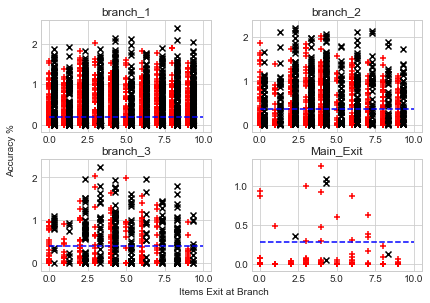

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,5000,0.6200,0.620000,0.190796,0.671800,2436,923,0.725216,0.733552,895,20,28
1,branch_2,1641,0.7228,0.614869,0.356268,0.619744,766,251,0.753196,0.759095,245,5,6
2,branch_3,624,0.7046,0.576923,0.397637,0.605769,274,104,0.724868,0.746032,96,3,8
3,Main_Exit,246,0.9850,0.979675,0.279995,0.926829,226,2,0.991228,1.000000,0,0,2


In [17]:
#### version 2
display(displayEvidence_cascade(validation_Outputs, Evidence = False))
# display(displayEvidence_cascade(test_Outputs, Evidence = False))

incorrects       label      evidence    Acc  overlap
0         3  1.246826e-01  False        1
5         6  3.475281e-03  False        1
10        0  3.799115e-02  False        1
15        8  1.336975e+00  False        1
24        5  1.411519e+00  False        1
25        2  6.786904e-01  False        1
30        6  1.403023e+00  False        1
32        4  7.098230e-04  False        1
35        2  6.887251e-01  False        1
36        4  1.011075e-01  False        1
40        4  4.227552e-07  False        1
46        3  3.116144e-01  False        1
51        8  4.436813e-01  False        1
52        0  1.750445e+00  False        1
53        3  6.223675e-03  False        1
57        7  1.124356e+00  False        1
58        4  7.916514e-04  False        1
67        2  1.221803e+00  False        1
68        3  2.948635e-06  False        1
69        7  4.351583e-01  False        1
71        6  7.000079e-01  False        1
76        9  1.181272e-01  False        1
77        3  1.514230e-

c:\users\sanity\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

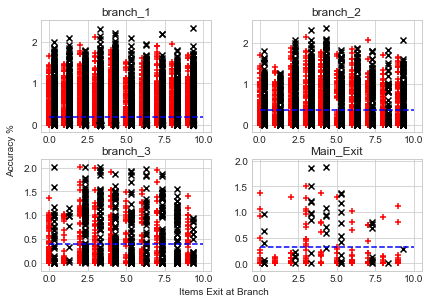

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,10000,0.6118,0.611800,0.190796,0.668700,4815,1872,0.720054,0.748916,1679,86,193
1,branch_2,3313,0.7193,0.606701,0.356268,0.596136,1446,529,0.732152,0.775696,443,38,86
2,branch_3,1338,0.7021,0.624813,0.397637,0.637519,623,230,0.730363,0.769050,197,17,33
3,Main_Exit,485,0.9500,0.903093,0.314520,0.880412,406,21,0.950820,1.000000,0,0,21


In [22]:
displayEvidence_cascade(test_Outputs, thresholds=[0.190796,0.356268,0.397637], Evidence = False)

incorrects       label  evidence    Acc  overlap
0         3  0.006962  False      1.0
3         0  0.011299  False      1.0
7         6  0.004514  False      1.0
8         3  0.012210  False      1.0
9         1  0.002061  False      1.0
10        0  0.002871  False      1.0
12        5  0.007778  False      1.0
13        7  0.003786  False      1.0
15        8  0.003118  False      1.0
22        4  0.003947  False      1.0
24        5  0.011967  False      1.0
25        2  0.006697  False      1.0
27        0  0.003072  False      1.0
31        5  0.005142  False      1.0
32        4  0.015654  False      1.0
33        5  0.011985  False      1.0
35        2  0.004270  False      1.0
36        4  0.011479  False      1.0
40        4  0.004452  False      1.0
42        5  0.005703  False      1.0
44        0  0.000908  False      1.0
46        3  0.009127  False      1.0
48        7  0.009349  False      1.0
49        6  0.007598  False      1.0
51        8  0.002276  False      1.0
5

c:\users\sanity\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


  std 0.0035235903269146785
1640
rollover enabled, 6778 predictions provided
incorrects       label  evidence    Acc  overlap
0         3  0.002418  False      1.0
7         6  0.001459  False      1.0
13        7  0.003429  False      1.0
15        8  0.004343  False      1.0
27        0  0.001732  False      1.0
35        2  0.002631  False      1.0
37        1  0.000546  False      1.0
40        4  0.000801  False      1.0
44        0  0.002349  False      1.0
57        7  0.003160  False      1.0
62        6  0.001539  False      1.0
66        1  0.005896  False      1.0
68        3  0.001198  False      1.0
71        6  0.002155  False      1.0
72        8  0.003888  False      1.0
74        0  0.000465  False      1.0
77        3  0.009969  False      1.0
78        3  0.009638  False      1.0
79        8  0.000908  False      1.0
83        7  0.004786  False      1.0
85        5  0.003130  False      1.0
87        7  0.001189  False      1.0
93        6  0.002051  False      1.0


<Figure size 432x288 with 0 Axes>

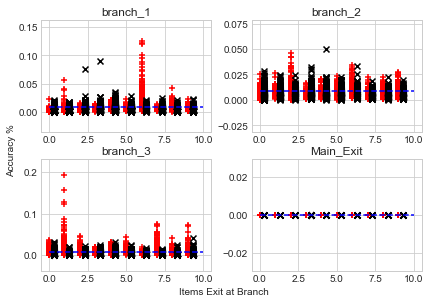

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,10000,0.4338,0.433800,0.009285,0.158200,874,708,0.552465,0.585967,655,13,53
1,branch_2,8418,0.5099,0.490734,0.008253,0.194821,1034,606,0.630488,0.657927,561,30,45
2,branch_3,6778,0.6665,0.635143,0.007197,0.214813,1195,261,0.820742,0.842033,230,21,31
3,Main_Exit,5322,0.9493,0.941000,0.000000,1.000000,5008,314,0.941000,1.000000,0,0,314


In [34]:
displayEvidence_cascade(test_Outputs, thresholds=[0.009285,0.008253,0.007197] ,Evidence = True)

In [19]:
display(displayEvidence_cascade(test_Outputs, Evidence = False))

NameError: name 'test_Outputs' is not defined

In [ ]:
'''     overlap
        if zero, both match, if else they don't match
        TT 1-1 =0
        TF 1-0 =1

        FT 0-1 = -1
        FF 0-0 =0
        
        '''
# print(Outputs[1])
displayEvidence(Outputs, Evidence = True)

In [ ]:
### 227,227 sigmoid evidence cifar10 v2
# print(Outputs[0])

displayEvidence(Outputs, Evidence = False)

In [ ]:
### 227,227 sigmoid evidence cifar10
displayEvidence(Predictions)

In [ ]:
### 227,227 sigmoid cifar10
displayEvidence(Predictions)

In [ ]:
### 32,32 crossEvidence cifar10
displayEvidence(Predictions)

In [ ]:

displayEvidence(Predictions)

In [ ]:
displayEvidence(Predictions)


In [ ]:
model_2 = tf.keras.models.load_model('alexNetv6_evidence_test.hdf5',
    custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"crossEntropy_loss":loss_function()})

In [ ]:
Predictions_2 = collectEvidence(model_2,test_ds)

In [ ]:
displayEvidence(Predictions_2)

In [ ]:
def collectEntropy(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
#     print(item)

    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    Outputs = pd.DataFrame()
    output_names=["mainExit"]
    pAcc=[]
    for i, (x,y) in enumerate(test_ds):
#     for i in range(100):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        result = model.predict(x)
        pClass.append(tf.argmax(y,1).numpy()[0])
        pred= (tf.nn.softmax(result)[0])

        pEvidence.append(calcEntropy_Tensors(pred).numpy())
        if np.argmax(pred) == np.argmax(y):
            pAcc.append(1)       
        else:
            pAcc.append(0)
    Predictions = pd.DataFrame({"label":pClass,"evidence":pEvidence,"Acc":pAcc,"overlap":0})
    return Predictions

def displayEntropy(Predictions):
    output_names=["mainExit"]
    Outputs=pd.DataFrame()
    Predictions["Acc"]=Predictions["Acc"].astype('bool')
    acc = Predictions["Acc"].value_counts()
    print(acc)
    print((acc.loc[True] , acc.loc[False]))
    mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
    std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]
    E_threshold = mean - std
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
    # Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
    print(acc)
    for i,name in enumerate(output_names):
        Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                "E_Threshold":E_threshold,
                # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                "acceptance_rate":Predictions.loc[(Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] < E_threshold)].count()[0],
                # "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                # "Incorrects_overlap":Incorrects_overlap,
                },index=[i]))

    # fig, axs = plt.subplots(1, 2)
    plt.suptitle('Horizontally stacked subplots')
    plt.scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
    plt.scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
    plt.plot(np.repeat(E_threshold,11),'b--')
    plt.title("evidence")


    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs
    


In [ ]:
# Entropy_predictions = collectEntropy(model_2,test_ds)


In [ ]:
displayEntropy(Entropy_predictions)

In [ ]:

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
test_images = test_images.reshape(10000, 32,32,3).astype("float32") / 255

# print(y_train)
K= 10 # number of classes
test_labels = tf.keras.utils.to_categorical(test_labels,10)
shuffle_size = 22500
batch_size=1
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

def augment_images(image, label,input_size=(227,227), channel_first = False):
            image = tf.image.resize(image,input_size)
            if channel_first:
                image = tf.transpose(image, [2, 0, 1])
            return image, label
test_ds_size = len(list(test_ds))
# test_ds = (test_ds.map(augment_images))
t_target = tf.data.Dataset.from_tensor_slices((test_labels))
test_ds = tf.data.Dataset.zip((test_ds,t_target))
test_ds = (test_ds.batch(batch_size=1, drop_remainder=True))

In [ ]:
Predictions_mse = collectEvidence(model,test_ds)

In [ ]:
displayEvidence(Predictions_mse)

In [ ]:
#sum entropy 
import pandas as pd
def entropy(x):
    return -(x * math.log(x))
# Data for plotting
t = np.arange(0.00001, 1, 0.01)
print(t.shape)
t_ = np.full((100,), .1)
df = pd.DataFrame([t,t,t_,t,t])
# print(df.transpose())
p = df.apply(calcEntropy,axis=0)
# print(p)
# print(p)
fig, ax = plt.subplots()
ax.plot(t, p)
ax.set(xlabel='Probability of Outcome',ylabel='Entropy of event')

plt.show()


In [ ]:
y_true = [0]
y_pred = [.99,.01, .01, .0, .01, .01]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

In [ ]:
y_true = [0,1,0,0,0,0]
y_pred = [.99,.01, .01, .0, .01, .01]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.CategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

In [ ]:
y_true = [0]
y_pred = [.0,.01, .9, .0, .0, .0]
ent = calcEntropy(y_pred)
print("Entropy: ",ent)
loss = ent *1
print("Loss: ",loss)

In [ ]:
y_true = [[0],[0],[0]]
y_pred = [[.9,.5, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]
y_pred = [[.9,.0,.0,.0,.0,.0,],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]
# y_pred = [.1,.1, .1, .1, .1, .1]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

''' When the answer is correct, CrossE goes down
    When 
    When its wrong, Entropy High
    When its right, Entropy Low
    
    so penalize being right with low entropy and reward being right with high entropy
    
    
    OORRRR train a second model for a branch to determine if you are going to get it right or not?
    Isn't that what ResNet Did? you calculate if the blocks will contribute, was it block drop?
    Binary classification,
    could be done at the branch end as a separate evaulator, using the entropy score and the input to the branch as inputs?
'''


ent = calcEntropy(y_pred)
print("Entropy: ",ent)
loss = crossE + ent
print("combined Loss: ",loss)

In [ ]:
x = [[.1,.1, .675, .1091, .4311, .1875,.121,.143,.2,.5]]
x = tf.constant([[2, 20, 30, 3, 6], [3, 11, 16, 1, 8],
                 [14, 45, 23, 5, 27]])

print(list(map(np.argmax,np.array(x))))
def foo(y_pred):
    y_pred = y_pred.numpy()
    pred_label = list(map(np.argmax,np.array(y_pred)))
    return pred_label
%timeit foo(x)

In [ ]:
y_true = tf.constant([[2],[2],[0]])
A = tf.constant([.1,.1, .675, .1091, .4311, .1875,.121,.143,.2,.5])
B = tf.constant([[2, 20, 30, 3, 6], [3, 11, 16, 1, 8],
                 [14, 45, 23, 5, 27]])

y_pred = tf.constant([[.9,.5, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]])

# new_list = new_list = [list(range(10)) for _ in range(10)]

print(tf.math.argmax(y_pred,1))
pred_labels = tf.math.argmax(y_pred,1)
print(tf.reshape(y_true,pred_labels.shape))
indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
indexes = tf.reshape(indexes,[-1])
# print(tf.gather(B,indexes))
CorrectE = tf.gather(y_pred,indexes)
print(CorrectE)
# print(calcEntropy(CorrectE[0]))


results = tf.map_fn(calcEntropy,tf.cast(CorrectE,'float'))
print("results: ",results)



%timeit tf.map_fn(calcEntropy,tf.cast(CorrectE,'float'))


crossE = tf.keras.losses.SparseCategoricalCrossentropy()
crossE(y_true,y_pred)
%timeit crossE(y_true,y_pred)
# [
#     [
#         [ 2 20 30  3  6]
#     ]
#     [
#         [ 3 11 16  1  8]
#     ]
# ]

def entropyAddition_noCross(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 0
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = correctEntropies
    return loss

In [ ]:
y_true = tf.constant([[1],[2],[0]])
y_pred = tf.constant([[0,0, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])
crossE = tf.keras.losses.SparseCategoricalCrossentropy()
def entropyAddition(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 0
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = scce + (correctEntropies * scce)
    return loss


print("normal CrossE: ",crossE(y_true ,y_pred))

print("normal Entropy",entropyAddition_noCross(y_true2,y_pred2))

print(entropyAddition(y_true2, y_pred2))
# %timeit entropyAddition(y_true, y_pred)

In [ ]:
y_true = tf.constant([1])
y_pred = tf.constant([0,1, 0, 0, 0, 0])
# print(crossE(y_true,y_pred))

print(tf.cast(1e-8,'float')+1)

In [ ]:
y_true = tf.constant([[1],[2],[0]])
y_pred = tf.constant([[.9,.1, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])
crossE = tf.keras.losses.SparseCategoricalCrossentropy()
def entropyMultiplication(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 1
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = correctEntropies * scce
    return loss


print("normal CrossE: ",crossE(y_true,y_pred))
print(entropyAddition(y_true, y_pred))
# %timeit entropyAddition(y_true, y_pred)

In [ ]:
y_true = tf.constant([[1],[2],[1]])
y_pred = tf.constant([[.9,.1, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])

def confidenceScore(y_true, y_pred):
        # print(y_pred)
        # print(tf.keras.backend.get_value(y_pred))
        
        # y_true =y_true.numpy()
        # y_pred = y_pred.numpy()
        # AvgConfidence = -1
        pred_labels = tf.math.argmax(y_pred,1)
        # countCorrect=0
        indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
        indexes = tf.reshape(indexes,[-1])
        entropies = tf.gather(y_pred,indexes)
        if tf.equal(tf.size(entropies), 0):
            correctEntropies = 0
        else:
            correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy,tf.cast(entropies,'float')))    
        
        return correctEntropies
    
print(confidenceScore(y_true,y_pred))

In [ ]:
y_true = [[2],[2],[0]]
y_pred = [[.9,0, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]

def foo(x, y):
    scce = tf.keras.losses.SparseCategoricalCrossentropy()
    crossE = scce(x, y).numpy()
    return crossE

print(foo(y_true,y_pred))
%timeit foo(y_true,y_pred)

In [ ]:

# Python program explaining 
# where() function 
  
import numpy as np
  
# a is an array of integers.
a = np.array([[1, 2, 3], [4, 5, 6]])
  
print(a)
  
print ('Indices of elements <4')
  
b = np.where(a<5)
print(b)
  
print("Elements which are <4")
print(a[b])

In [ ]:
y_true = [[0],[0],[0]]
y_pred = [[.5,.5, .6, .5, .5, .1],[.5,.5, .6, .5, .5, .2],[.5,.5, .6, .5, .5, .3]]
# y_pred = [[1],[1],[1]]
# print(np.array(y_pred))

####
# Numpy confidence metric version
y_true =np.array(y_true)
y_pred = np.array(y_pred)
def argmax(x):
    return [np.argmax(x)]
pred_labels = list(map(argmax,np.array(y_pred)))
x = np.where(np.equal(y_true,pred_labels) ==True)
y = y_pred[x[0]]
results = calcEntropy(y)
print(results)
if not (results):
    print("A")
print(np.median(results))


In [ ]:
y_true = [[2],[2],[0]]
y_pred = [[.5,.5, .6, .5, .5, .5],[.5,.5, .6, .5, .5, .5],[.5,.5, .6, .5, .5, .5]]

y_true = [[2]]
y_pred = [[.1,.1, .15, .1, .1, .1]]
def entropyAddition_loss():
    #create a wrapper function that returns a function
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    def entropyAddition(y_true, y_pred):
        #Entropy is added to the CrossE divided by the len of inputs
        pred_labels = tf.math.argmax(y_pred,1)
        indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
        indexes = tf.reshape(indexes,[-1])
        entropies = tf.gather(y_pred,indexes)
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy,tf.cast(entropies,'float')))
#         print(pred_label)
        scce = crossE(y_true, y_pred)
        sumEntropy = 0
        loss = correctEntropies + scce
        return loss
    
    return entropyAddition

def custom_loss_multi(y_true, y_pred):
    #CrossE is multiplied by the Entropy
    pred_label = list(map(np.argmax,np.array(y_pred)))
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    sumLoss = 0
    
    for i in range(len(y_pred)):
        loss = crossE(y_true[i], y_pred[i])
#         print('crossE: ',loss)
        if pred_label[i] == y_true[i]:
#             print('calcEntropy ',calcEntropy(y_pred[i]))
            loss = loss * calcEntropy(y_pred[i])
        sumLoss += loss
    sumLoss = sumLoss / len(y_pred)         
    
#     loss = crossE(y_true, y_pred)
#     print("CrossE : ",loss.numpy())
#     print("Loss : ",sumLoss)
    return sumLoss
    ### I want to reduce the entropy of correct answers
    ### if label - pred = 0 (aka correct) then add entropy to crossE
    
    
#     squared_difference = tf.square(np.array(y_true) - np.array(y_pred))
#     return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossEntropyLoss: ",crossE)


crossE = custom_loss_addition(y_true, y_pred).numpy()
print("customLoss_addition: ",crossE)


crossE = custom_loss_multi(y_true, y_pred).numpy()
print("customLoss_multi: ",crossE)

  
# model.compile(loss=custom_loss, optimizer='adam')



In [ ]:

def sub(x,y):
    if x - y == 0:
        return 1
%timeit sub(5,5)

In [ ]:

def sub(x,y):
    if x == y:
        return 0
    
%timeit sub(5,5)